<a href="https://colab.research.google.com/github/rontalapoojareddy/DeepLearning1/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2503B05130**

**R.Pooja Reddy**

**M.Tech(CSE)**


**Environment Setup**

In [24]:
pip install torch torchvision transformers datasets pillow matplotlib tqdm


**Create Folders**

In [26]:
!mkdir -p dataset/images
!mkdir models
!mkdir outputs



**Confirm Image Names**

In [27]:
import os
print(os.listdir("dataset/images"))


['img1.jpg', 'img2.jpg', '.ipynb_checkpoints']


**Create captions.txt File**

In [28]:
with open("dataset/captions.txt","w") as f:
    f.write("img1.jpg|a small yellow bird with black wings\n")
    f.write("img2.jpg|a red flower with long petals\n")

print("captions file created")


captions file created


**Check captions file**

In [29]:
with open("dataset/captions.txt") as f:
    print(f.read())


img1.jpg|a small yellow bird with black wings
img2.jpg|a red flower with long petals



**Test Dataset Loader**

In [30]:
from PIL import Image
from torch.utils.data import Dataset

class TextImageDataset(Dataset):
    def __init__(self, image_dir, caption_file):
        self.image_dir = image_dir
        self.data = []

        with open(caption_file) as f:
            for line in f:
                img, cap = line.strip().split("|")
                self.data.append((img, cap))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        return img_name, caption

dataset = TextImageDataset("dataset/images","dataset/captions.txt")

print(dataset[0])


('img1.jpg', 'a small yellow bird with black wings')


**Import Libraries**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt


**Image Transform Setup**

In [32]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])


**Full Dataset Loader** (Real Version)

In [33]:
class TextImageDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        with open(caption_file) as f:
            for line in f:
                img, cap = line.strip().split("|")
                self.data.append((img, cap))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        img = self.transform(img)
        return img, caption

dataset = TextImageDataset("dataset/images","dataset/captions.txt",transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)


**Load BERT Text Encoder**

In [34]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

def encode_text(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        out = bert(**tokens)
    return out.pooler_output


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Generator Model**

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100+768, 256*8*8)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64,3,4,2,1),
            nn.Tanh()
        )

    def forward(self, z, text):
        x = torch.cat([z, text], dim=1)
        x = self.fc(x).view(-1,256,8,8)
        return self.net(x)


**Discriminator Model**

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3,64,4,2,1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.fc1 = nn.Linear(128*16*16, 512)
        self.fc2 = nn.Linear(512+768, 1)

    def forward(self, img, text):
        x = self.conv(img).view(img.size(0), -1)
        x = self.fc1(x)
        x = torch.cat([x, text], dim=1)
        return torch.sigmoid(self.fc2(x))


**Initialize Models**

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=0.0002)
optD = optim.Adam(D.parameters(), lr=0.0002)


**Training Loop** (Small Demo Training)

In [38]:
for epoch in range(5):
    for imgs, captions in loader:

        imgs = imgs.to(device)
        text = encode_text(list(captions)).to(device)

        b = imgs.size(0)
        real = torch.ones(b,1).to(device)
        fake = torch.zeros(b,1).to(device)

        z = torch.randn(b,100).to(device)
        fake_imgs = G(z, text)

        # Train D
        d_loss = loss_fn(D(imgs,text), real) + loss_fn(D(fake_imgs.detach(),text), fake)
        optD.zero_grad(); d_loss.backward(); optD.step()

        # Train G
        g_loss = loss_fn(D(fake_imgs,text), real)
        optG.zero_grad(); g_loss.backward(); optG.step()

    print("Epoch",epoch,"D:",d_loss.item(),"G:",g_loss.item())


Epoch 0 D: 1.3383228778839111 G: 16.956329345703125
Epoch 1 D: 0.006530216429382563 G: 10.874914169311523
Epoch 2 D: 0.2621627449989319 G: 11.539705276489258
Epoch 3 D: 0.34924280643463135 G: 12.999187469482422
Epoch 4 D: 0.06891839951276779 G: 13.114013671875


**Generate Image From Text**

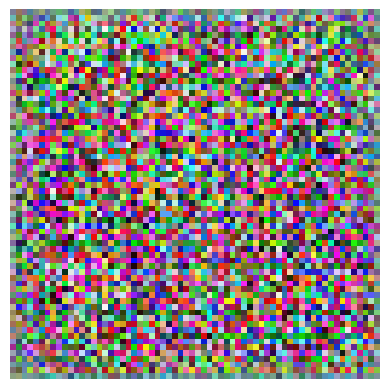

In [40]:
def show(img):
    img = img.detach().cpu()
    img = (img + 1) / 2
    img = img.clamp(0,1)

    plt.imshow(img[0].permute(1,2,0))
    plt.axis("off")
    plt.show()


prompt = ["a small yellow bird"]

# encode text
text = encode_text(prompt)
text = text.to(device)

# noise
z = torch.randn(1,100).to(device)

# generate
with torch.no_grad():
    fake_img = G(z, text)

show(fake_img)


**Save Models**

In [41]:
torch.save(G.state_dict(),"models/generator.pth")
torch.save(D.state_dict(),"models/discriminator.pth")


**Debug Check**

In [42]:
print("z shape:", z.shape)
print("text shape:", text.shape)


z shape: torch.Size([1, 100])
text shape: torch.Size([1, 768])
